Implemenation and notes of backpropagation in its simplest form.

Backpropagation is essentially applying chain rule on your function. Gets the derivative of each variable, determing the impact of each variable on the overall output. 

Neural nets are the large scale operation of backprop, essentially iterating upon mathematical expressions.

In [356]:
import math
import numpy as np

In [357]:
class Value:
  #constructor
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label
      
  #string representation
  def __repr__(self):
    return f"Value(data={self.data}, label={self.label})"

  #add operator
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+') 

    def _backward():
        self.grad = 1.0 * out.grad
        other.grad = 1.0 * self.grad 
    out._backward = _backward
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
        self.grad = other.data * out.grad
        other.grad = self.data * out.grad
    out._backward = _backward
    return out 

  def tanh(self):
    n = self.data
    #tanh = (math.exp(n) - math.exp(-n)) / (math.exp(n) + math.exp(-n)) --> longer expression
    tanh = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
    out = Value(tanh, (self, ), label='tanh')

    def _backward():
      self.grad += (1 - tanh**2) * out.grad #derivative of tanh and chain rule
    out._backward = _backward
    return out

In [358]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0, label=L)

In [359]:
f.grad = 4; #L = d*f and d = e+c = 4
d.grad = -2 #L = d*f and f = -2
L.grad = 1

In [360]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

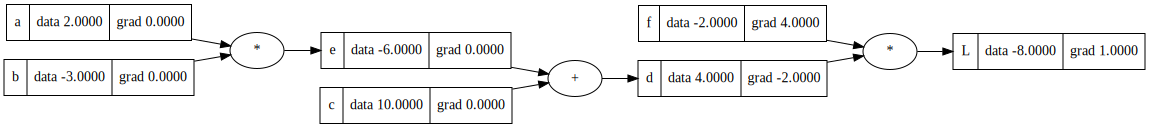

In [361]:
draw_dot(L)

We manually calculate first order derivative dL/dd and dL/df. 

Now we need to calculate dL/de and dL/dc

This invokes chain rule. We leverage the already known gradients dL/dd and dL/df.

dL/de = dL/dd * dd/de = -2 * dd/de

and dL/dc = dL/dd * dd/dc = 4 * dd/dc

We must solve for the two remaining terms by calculating their first order derivative.

d = e+c

dd/de = 1 (e is a linear function)
dL/de = dL/de = dL/dd * dd/de = -2 * dd/de = -2 * 1 = -2

dd/dc = 1 (c is also a linear function)
dL/dc = dL/dd * dd/dc = -2 * dd/dc = -2 * 1 = -2

In [362]:
e.grad = -2
c.grad = -2

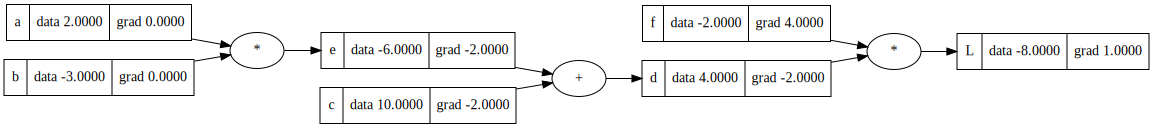

In [363]:
draw_dot(L)

now we need dL/db and dL/da.

for brevity, we can spell out the entire chain rule algorithm here.

dL/db = dL/dd * dd/de * de/db  
dL/da = dL/dd * dd/de * de/da 

We know dL/dd * dd/de = -2 from our last expression (this is also e.grad)

dL/db = -2 * de/db 
dL/da = -2 * de/da

e = a*b
de/da = b = -3
de/db = a = 2 

dL/db = -2 * de/db = -2 * 2  = -4  
dL/da = -2 * de/da = -2 * - 3= 6 

All local derivatives are calculated. Backprop is essentially the recursive application of chain rule.

In [364]:
b.grad = -4
a.grad = 6

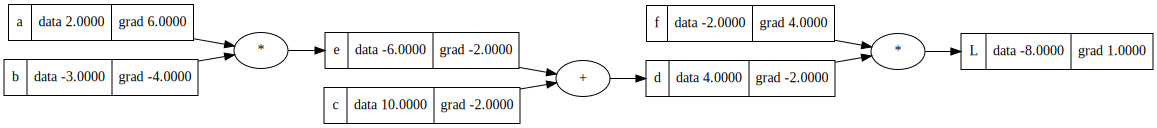

In [365]:
draw_dot(L)

We want to nudge our inputs to make L go up. We nudge each node in the direction of the gradient. We only do this for leaf nodes (those listed in cell below) as these are typically cells we have control over (deeper nodes are generally hidden layers and are obfuscated from user POV)

In [366]:
a.data+= 0.01*a.grad
b.data+= 0.01*b.grad
c.data+= 0.01*c.grad
f.data+= 0.01*f.grad

#forward pass to see how new data impacts hidden layers and output L node 
e = a * b
d = e + c
L = d * f

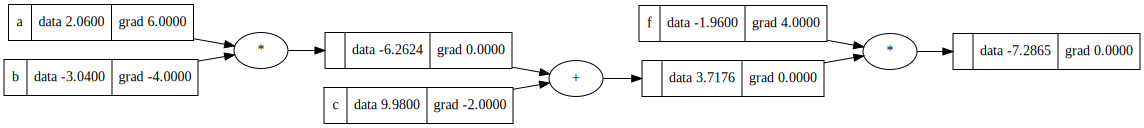

In [367]:
#forward pass
draw_dot(L)

Restart and build a self sufficeint neural network without the need to self calculate the gradients at each step. New formula and weights with two variable, x1, x2

In [368]:
#x1 and x2 are inputs. 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#w1 and w2 are weights.
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label = 'w2')

#neuron bias. may help us achieve a better fit to input data.
b = Value (6.8813735870195432, label='b');

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); 

In [382]:
n._prev

{Value(data=-6.0, label=x1w1x2w2), Value(data=6.881373587019543, label=b)}

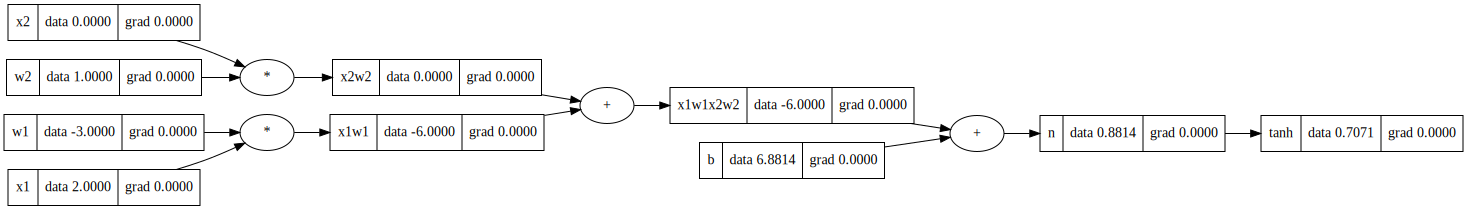

In [369]:
draw_dot(o)

Hand calculate gradients

a. dO/dO = 1  
b. dO/dn = sech^2(n)  (derivative of tanh(x)) = sech^2(0.8814) = .5  
c. dO/db = d0/dn * dn/db = .5 * d(x1w1x2w2 + b)/ db = .5 * 1 = 1 (although b is a constant)  
d. dO/(x1w1 + x2w2) = d0/dn * dn/(x1w1 + x2w2) = sech^2(n) + 0 =  = .5  
e. dO/(x1w1) = dO/(x1w1 + x2w2) * d(x1w1 + x2w2)/d(x1w1) = .5 * 1 = .5  
f. dO/(x2w2) =  dO/(x1w1 + x2w2) * d(x1w1 + x2w2)/d(x2w2) = .5 * 1 = .5  
g. dO/(w2) = dO/d(x2w2) * d(x2w2)/d(w2) = .5 * x2 = .5 * 0 = 0  
h. dO/(w1) = dO/(x1w1) * dO/w1 = .5 * x1 = .5 * 2 = 1  



In [370]:
# o.grad = 1.0
# n.grad=.5
# x1w1x2w2.grad = .5
# x1w1.grad = .5
# x2w2.grad = .5

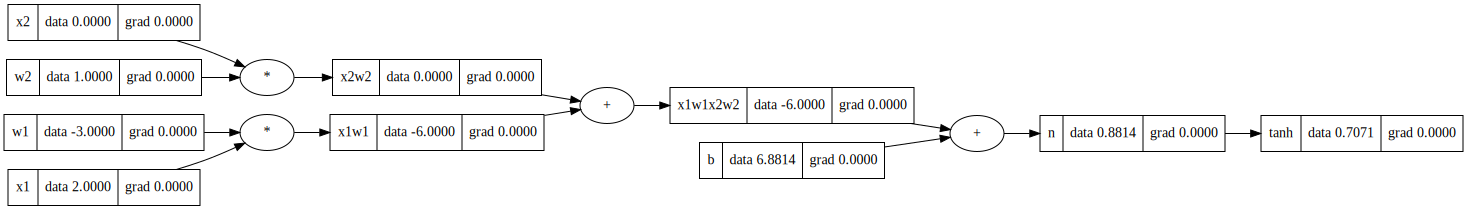

In [371]:
draw_dot(o)

In [372]:
o.grad = 1.0

In [373]:
o._backward()

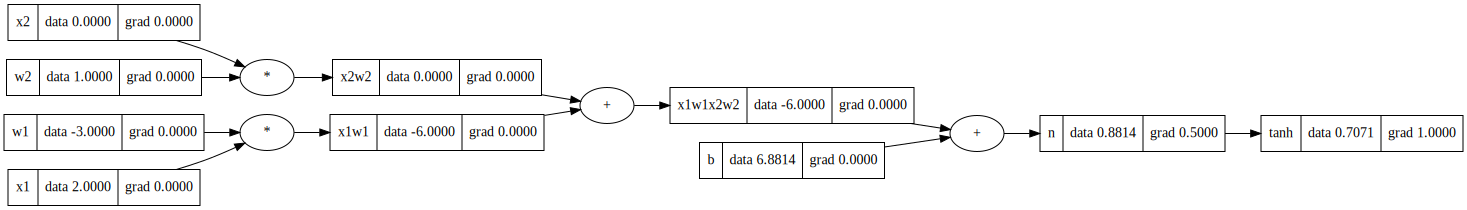

In [374]:
draw_dot(o)

In [375]:
n._backward()

In [376]:
x1w1x2w2._backward()

In [377]:
x1w1._backward()
x2w2._backward()

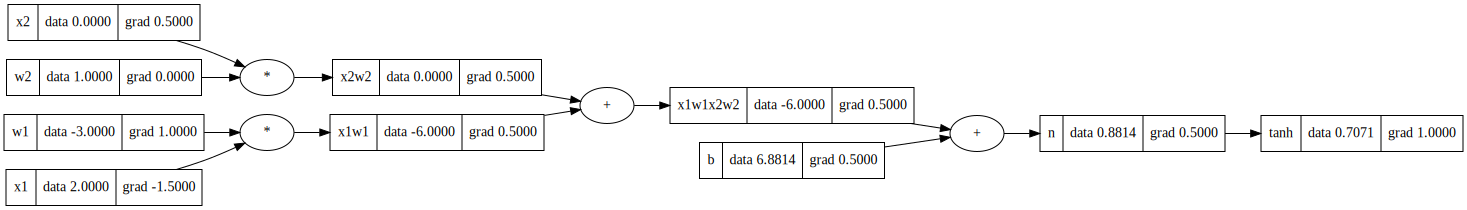

In [378]:
draw_dot(o)

How do we automate this? Topological sort helps us sort the graph such that all the dependencies are laid out left to right, with the one with the most dependencies on the left and least on the right. 

In [388]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=1.0, label=w2),
 Value(data=0.0, label=x2),
 Value(data=0.0, label=x2w2),
 Value(data=-3.0, label=w1),
 Value(data=2.0, label=x1),
 Value(data=-6.0, label=x1w1),
 Value(data=-6.0, label=x1w1x2w2),
 Value(data=6.881373587019543, label=b),
 Value(data=0.8813735870195432, label=n),
 Value(data=0.7071067811865476, label=tanh)]